
In this study we uncover the effects and interactions of procedural changes made by the company to decrease the level of denied claims. The measurement periods in question are the first and second half of calendar year 2016. We are tasked with uncovering the nature of the implementation: whether it targeted denial types, insurance carriers, service lines or claims by dollar amount - and possibly a combination of these.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import warnings
import seaborn as sbs

A preview of the raw dataset. Here, you see that 
 - 'month of service' is nearly qualitative 
 - 'Denied Amount' is continuous for all intents and purposes
 - 'Insurance Name' is categorical
 - 'Service Line' is Categorical
 - 'Denial Type' is Categorical

In [2]:
df=pd.read_excel('/home/lechuza/Documents/hr/Flatiron_Analyst_Case_Study_(2).xlsx')
df.head()

,Month of Service,Denied Amount,Insurance Name,Service Line,Denial Type
0,7,31000,Aetna,MedOnc,Authorization
1,9,11000,Medicaid,Radiology,Credentialing
2,6,5000,UHC,MedOnc,Timely Filing
3,8,13000,Medicaid,E&M,Additional Information
4,5,39000,HIP,Labs,Coding


Note: the data shows one half of the story. Not provided is information on these factors across sucessful and denied claims. In effect, I am provided a biased subset of the data. One reprecussion is lack of insight into relative proportion of claims to denials filed to a particular carrier or for a particular service line. Thus we can only make recommendations from one side of the dataset.

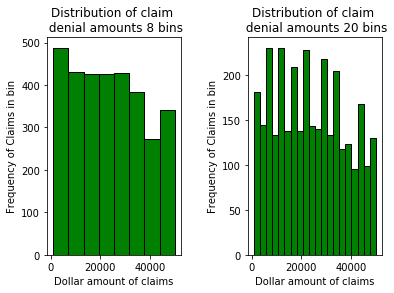

In [54]:
#bins=min(df['Denied Amount'])
plt.close()
ax1=plt.subplot(121)
plt.hist(df['Denied Amount'],bins=8,density=False,color='green',edgecolor='black')
plt.title('Distribution of claim \n denial amounts 8 bins')
plt.xlabel('Dollar amount of claims')
plt.ylabel('Frequency of Claims in bin')

plt.subplot(122)
plt.hist(df['Denied Amount'],bins=20,density=False,color='green',edgecolor='black')
plt.title('Distribution of claim \n denial amounts 20 bins')
plt.xlabel('Dollar amount of claims')
plt.ylabel('Frequency of Claims in bin')
plt.subplots_adjust(wspace=.5)

plt.show()
plt.close()

The above graphs displays the semi-uniform distribution of claim sizes across periods. Below we plot hisotgrams for each period separately.

In [5]:
#splitting dataset into first and second half of year
first_half=df.loc[df['Month of Service'] <7,:]
second_half=df.loc[df['Month of Service'] >6,:]

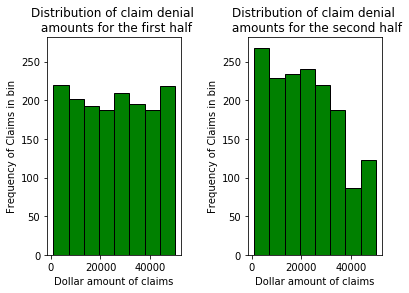

In [42]:
#first half binned histogram of claim sizes

plt.close()

ax2=plt.subplot(122)
plt.hist(second_half['Denied Amount'],bins=8,density=False,color='green',edgecolor='black')
plt.title('Distribution of claim denial \n amounts for the second half')
plt.xlabel('Dollar amount of claims')
plt.ylabel('Frequency of Claims in bin')

plt.subplot(121,sharey=ax2)
plt.hist(first_half['Denied Amount'],bins=8,density=False,color='green',edgecolor='black')
plt.title('Distribution of claim denial \n amounts for the first half')
plt.xlabel('Dollar amount of claims')
plt.ylabel('Frequency of Claims in bin')
plt.subplots_adjust(wspace=.5)
plt.show()

There was a significant decrease in claims over $35K... we'll check on that later.

In [56]:
#create dataframe of frequencies of the variables I want to plot
#will need to sort the series by index - alphabetical order
dt_1=first_half['Denial Type'].value_counts()
dt_2=second_half['Denial Type'].value_counts()

dt_d1=first_half.groupby('Denial Type').apply(lambda x: sum(x['Denied Amount']))
dt_d2=second_half.groupby('Denial Type').apply(lambda x: sum(x['Denied Amount']))
#sort both series and store as such

In [57]:
dt_d1.head()

Denial Type
Additional Information    4011000
Authorization             7054000
Coding                    7274000
Credentialing             7380000
Eligibility               3956000
dtype: int64

In [7]:
#sort these series
dt_1.sort_index(inplace=True)
dt_2.sort_index(inplace=True)

Plot denial types for first and second half of year

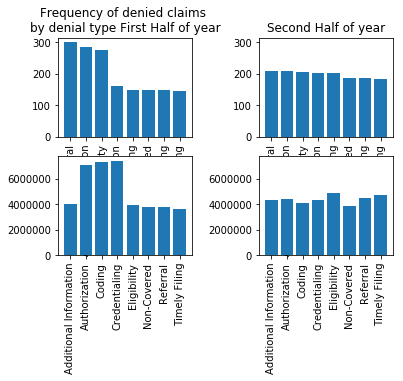

In [70]:
plt.close()
ax1=plt.subplot(221)
plt.bar(np.arange(1,len(dt_1)+1),dt_1.values)
ax1.set_title('Frequency of denied claims \nby denial type First Half of year')
plt.xticks(np.arange(1,len(dt_1)+1),np.array(dt_1.index),rotation=90.0)
#plt.figure(num=1,figsize=(5,1))

ax2=plt.subplot(222,sharey=ax1,sharex=ax1)
plt.bar(np.arange(1,len(dt_2)+1),dt_2.values,align='center')
ax2.set_title('Second Half of year')
plt.xticks(np.arange(1,len(dt_2)+1),np.array(dt_2.index),rotation=90.0)
#plt.figure(num=2,figsize=(5,1))

ax3=plt.subplot(223)
plt.bar(np.arange(1,len(dt_d1)+1),dt_d1.values,align='center')
ax2.set_title('Second Half of year')
plt.xticks(np.arange(1,len(dt_d1)+1),np.array(dt_d1.index),rotation=90.0)
#plt.figure(num=3,figsize=(5,5))

ax4=plt.subplot(224,sharey=ax3,sharex=ax3)
plt.bar(np.arange(1,len(dt_d2)+1),dt_d2.values,align='center')
ax2.set_title('Second Half of year')
plt.xticks(np.arange(1,len(dt_d2)+1),np.array(dt_d2.index),rotation=90.0)
#plt.figure(num=4,figsize=(5,1))

#plt.tight_layout() <- can't use, because it reduces the image sizes to the point where diminishing legibility
plt.subplots_adjust(wspace=.5)
plt.show()

We note that denials increased for all types save for "Authorization", "Coding" and "Credentialing". Later, we do a deeper dive to check the distribution across component service lines for each of these claims using a rate of change metric.

Nominal dollar amount of denials by carrier.

In [9]:
insurance_sums_first=first_half.groupby('Insurance Name').apply(lambda x: sum(x['Denied Amount']))
insurance_sums_second=second_half.groupby('Insurance Name').apply(lambda x: sum(x['Denied Amount']))

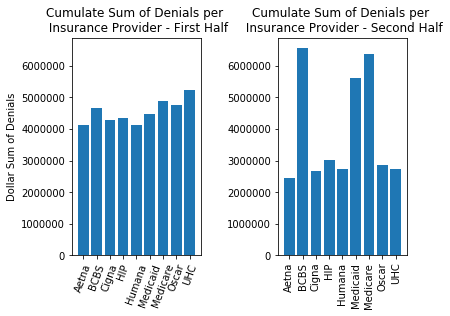

In [48]:
#it would be nice to show gridlines
plt.close()
ax1=plt.subplot(121)
plt.bar(np.arange(1,len(insurance_sums_first)+1),insurance_sums_first.values)
plt.xticks(np.arange(1,len(insurance_sums_first)+1),np.array(insurance_sums_first.index),rotation=70.0)
plt.ylabel('Dollar Sum of Denials')
plt.title('Cumulate Sum of Denials per \n Insurance Provider - First Half')


ax2=plt.subplot(122, sharey=ax1)
plt.bar(np.arange(1,len(insurance_sums_second)+1),insurance_sums_second.values)
plt.xticks(np.arange(1,len(insurance_sums_second)+1),np.array(insurance_sums_second.index),rotation=90.0)
plt.title('Cumulate Sum of Denials per \n Insurance Provider - Second Half')
plt.subplots_adjust(wspace=.6)
#plt.tight_layout()
plt.show()

We already start to see some notable differences between the two periods in the array of visuals above:
1. Cumulative denials fell dramatically for all insurance carriers, save for BCBS, Medicaid and Medicare
2. Fewer denials of less than $35K

We can drill down to see whether there is a level among the Service Line and Denial Type factors that is prevalent in the subset of carriers. Perhaps a 'denial type' or 'service line' is more significantly prevalent in one of the groups over the others. If not, we can try the study from a different perspective: Beginning the analysis from the denial types, then proceeding through servie line, and if need be, insurance carriers.  

In [11]:
service_sums_first=first_half.groupby('Service Line').apply(lambda x: sum(x['Denied Amount']))
service_sums_second=second_half.groupby('Service Line').apply(lambda x: sum(x['Denied Amount']))

We concentrate on Denial Types for now. We want to gauge the change in dollar denial amounts when plotting denial types along with service line. Below we plot a heat map with the quantity being the ratio of total dollars denied by combination of service line and denial type. Positive ratios mean that the total denied dollars increased in the second half and decimals signal a decline.

In [12]:
g1=first_half.groupby(['Denial Type','Service Line']).apply(lambda x: sum(x['Denied Amount']))
g2=second_half.groupby(['Denial Type','Service Line']).apply(lambda x: sum(x['Denied Amount']))

In [13]:
h=pd.concat([g1,g2],axis=1)

In [14]:
#unpack the multi index, merge, then apply a function to calculate the h/h difference change and rate of change
def innerFunction(rowwise):
    x=rowwise.tolist()
    #dic={'prop':x[1]/x[0],'diff':x[1]-x[0]}
    #dic=x[1]/x[0]
    dic=(x[1]/x[0],x[1]-x[0])
    return(dic)
#merge on multi index
def merge_calc(df1,df2):
    #df is a dataframe
    df=pd.concat([df1,df2],axis=1)
    final=df.apply(innerFunction,axis=1)
    return(final)

test=merge_calc(g1,g2)

In [15]:
#now we convert to an appropriate dataframe and plot a heatmap
test.columns=['proportion','difference']
test.reset_index(inplace=True)
test1=test.pivot('Service Line','Denial Type','proportion')

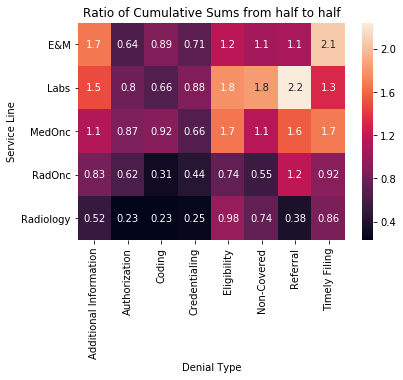

In [16]:
plt.close()
ax=sbs.heatmap(test1,annot=True)
ax.set_title('Ratio of Cumulative Sums from half to half')
#flights = sbs.load_dataset("flights")
#flights = flights.pivot("month", "year", "passengers")

#print(flights.head())
plt.show()
plt.close()

From the heatmap, we see that possible implementations of new "Coding", "Authorization" and "Credentialing" practices was especially effective at reducing claims across service lines when measured on ratio of cumulative dollar sum. This impact is notably effective in the service lines of 'RadOnc' and 'Radiology'.

Areas of concern: The procedural enhancements were least effective at reducing claims for "E&M", "Labs" and "MedOnc"; moreover, these three service lines experienced the highest growth in claims

Plot another HeatMap but with total absolute dollars difference half-over-half.

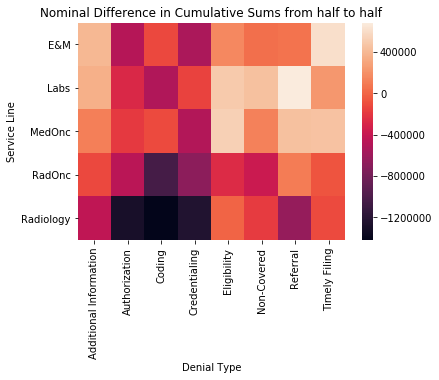

In [17]:
test2=test.pivot('Service Line','Denial Type','difference')
plt.close()
ax=sbs.heatmap(test2,annot=False)
ax.set_title('Nominal Difference in Cumulative Sums from half to half')
plt.show()
plt.close()

From the above, we can nearly rest assured that rates of change associate closely with changes as measured by nominal differences in cumulative denial dollars.

Below we re-do the study but starting with service lines.

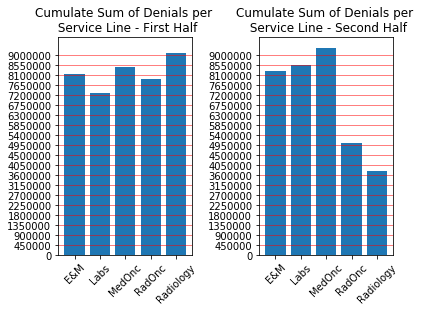

In [72]:
plt.close()

ax1=plt.subplot(121)
plt.bar(np.arange(1,len(service_sums_first)+1),service_sums_first.values)
plt.xticks(np.arange(1,len(service_sums_first)+1),np.array(service_sums_first.index),rotation=45.0)
plt.title('Cumulate Sum of Denials per \n Service Line - First Half')
plt.yticks(np.arange(0,max(service_sums_first.values)+8000,450000))
ax1.grid(color='r', linestyle='-', linewidth=.5, axis='y')


ax2=plt.subplot(122,sharey=ax1)
plt.bar(np.arange(1,len(service_sums_second)+1),service_sums_second.values)
plt.xticks(np.arange(1,len(service_sums_second)+1),np.array(service_sums_second.index),rotation=45.0)
plt.title('Cumulate Sum of Denials per \n Service Line - Second Half')
plt.yticks(np.arange(0,max(service_sums_second.values)+8000,450000))
ax2.grid(color='r', linestyle='-', linewidth=.5, axis='y')
plt.subplots_adjust(wspace=.5)

plt.show()

The h/h rate of change for each service line indicate that the last two had the most dramatic decline and absolute change, while 'MedOnc' had the largest increase. This confirms the drop we saw in these lines when taking the perspective of a 'denial type' implementation. It is possible that the firm focused on Service Lines and not denial types. We have to uncover the reason why denials decreased more for some service lines than others for "Coding", "Credentialing" and "Authorization".

In [19]:
np.array(service_sums_second)/np.array(service_sums_first)

array([ 1.01731761,  1.17605054,  1.10252776,  0.63521536,  0.41663919])

Wow! From the above, we determine that Radial Oncology and Radioliogy Denied Claims in dollars plummeted. But are the underlying components comparable - lending itself to an apples-to-apples comparison?
 - We'll be assuming that each measurement period had the same level of activity (number of claims)... we'll check the frequency of denials across periods for each of the service lines
 - We assume that the distribution of denials by carrier remains the same in both periods

Let's look at the distribution of the denial types across each service line. Then, we can plot a heatmap or plot the proportional decrease from each of the denial types. Then, we move on to answer why this was not successful in other Service Lines.

In [20]:
#for i in ['MedOnc','RadOnc','Radiology']
#create a function that accepts one service line category, and calculates the rank for each insurance provider,
#and their proportional change in absolute denial dollars h/h for that service line; measure the proportion each carrier to the entire service line, and flag those with greatest change
def distributionCarrier(sl,df1,df2):
    #df1.loc[df1['Service Line'],:]
    #multiple group by
    df1.groupby(['Service Line','Denial Type']).sum()

In [21]:
#first_half.groupby(['Service Line','Denial Type']).sum()
#second_half.groupby(['Service Line','Denial Type']).sum()

Compute difference, ratio of change in frequency of claims, then the average size of claims, total dollar amount of claims.

'Insurance Name' is categorical
'Service Line' is Categorical
'Denial Type'

Create a function that automatically builds all the elements of a combination across all three categorical variable and stores them in a list... UPDATE: don't need to create this, itertools can handle.

In [22]:
def combo(x,y,z)

SyntaxError: invalid syntax (<ipython-input-22-2650e4b7191f>, line 1)

In [ ]:
ins=df['Insurance Name'].unique()
service=df['Service Line'].unique()
denial=df['Denial Type'].unique()
lista=[ins,service,denial]
g=itertools.product(*lista)
combo_list=list(g)

In [ ]:
type(combo_list)

In [ ]:
#combo_list[7][1] #a list
g=np.array(first_half.loc[(first_half['Insurance Name'] == combo_list[7][0]) &
                        (first_half['Service Line'] == combo_list[7][1]) & 
        (first_half['Denial Type'] == combo_list[7][2]),'Denied Amount'])

np.mean(g)
g.size
np.sum(g)

Index the dataframe by the elements in each of the elements of this combination container, and use to calculate and arrive at the depenedent variable (frequency of claims, average claim, total amount of claims).

In [ ]:
#this function will be applied to a dataframe... the apply function, however, will not work
def getMeasure(df,index_array):
    #hard coding the index-column association
    #insert/place result set in either a dictionary, pandas dataframe
    result_set_dict={}
    result_set_dict.setdefault(index_array,{})
    #results_array is a pandas series
    results_array=np.array(df.loc[(df['Insurance Name'] == index_array[0]) & (df['Service Line'] == index_array[1]) & 
        (df['Denial Type'] == index_array[2]),'Denied Amount'])
    try:
        result_set_dict[index_array]['mean']=np.mean(results_array)
    except RunTimeWarning:
        result_set_dict[index_array]['mean']=None
    result_set_dict[index_array]['freq']=results_array.size
    result_set_dict[index_array]['cum_sum']=np.sum(results_array)
    return(result_set_dict)

In [ ]:
result_set1=[getMeasure(first_half,i) for i in combo_list]
result_set2=[getMeasure(second_half,i) for i in combo_list]

In [ ]:
def nested_dic(dic_list):
    #convert a nested dictionary into a dataframe
    tuple_list=[]
    values_list=[]
    for i in dic_list:
        for k,v in i.items():
            tuple_list.append(k)
            values_list.append(v)
    return((tuple_list,values_list))

key_list,value_list=nested_dic(result_set1)
#from second_half dataframe
key_list2,value_list2=nested_dic(result_set2)

In [ ]:
#first_half dataframe
df1=pd.DataFrame.from_records(value_list,index=key_list)
#second_half dataframe
df2=pd.DataFrame.from_records(value_list2,index=key_list2)

Now we have two dataframes, each dataframe contains the mean, cumulative sum and frequency of each combination of Service Line, Insurance Name, Denial Type. We can now calculate the difference between these values, as well as the rate of change across the two time periods.

In [ ]:
#this function is designed to be 'applied' to one of the dataframes... apply this to the first_half df
def lookUpDifference(x,df):
    dicty={}
#    dicty.setdefault(x.name,{})
    matched_row=df.loc[[x.name]].to_dict(orient='list')
    dicty[x.name]={'mean_diff':matched_row['mean']-x['mean'],
    'cum_sum_diff':matched_row['cum_sum']-x['cum_sum'],
    'freq_dif':matched_row['freq']-x['freq'],
    'mean_prop':matched_row['mean']/x['mean'],
    'cum_sum_prop':matched_row['cum_sum']/x['cum_sum'],
    'freq_prop':matched_row['freq']/x['freq']}
    return(dicty)

#

In [ ]:
g=df2.index[9]
h=df2.loc[[g]]
#print(df2.head())
#print(h)
dic=h.to_dict(orient='list')
print(dic)
#dic['mean']

In [ ]:
type(h)
h.shape
jh=h.iloc[0,:]
type(jh)

In [ ]:
#df1.loc[,:]
print(df1.index[9])
g=df1.index[9]
type(g)
df1.loc[[g]]

In [ ]:
g=df2.iloc[3,:]
df1.loc[[g.name]]['mean']-g['mean']

In [ ]:
gh=lookUpDifference(df2.iloc[3,:],df1)
type(gh)

In [ ]:
#apply to a DataFrame... in this case, returning a Series
g=df1.apply(lookUpDifference,args=(df2,),axis=1)

In [ ]:
vals=g.values
print(type(vals))
#new_df=pd.DataFrame(vals)
print(vals.shape)
vals[8:14]

In [ ]:
def nested_dic2(dic_list):
    #convert a nested dictionary into a dataframe
    tuple_list=[]
    final_vals=[]
    for i in dic_list:
        for k,v in i.items():
            tuple_list.append(k)
            #place the dictionary elements into a sublist... but need to sort the dictionary first
            values_list=[]
            for j,l in v.items():
                values_list.append(l[0])
        final_vals.append(values_list)
    return((tuple_list,final_vals))

In [ ]:
finished_tup,finished_vals=nested_dic2(vals)

In [ ]:
len(finished_tup)
#finished_tup[0:4]
len(finished_vals)
finished_vals[2:7]

In [ ]:
df13=pd.DataFrame.from_records(finished_vals,index=finished_tup,columns=['mean_diff','cum_sum_diff',
    'freq_diff','mean_prop','cum_sum_prop','freq_prop'])

In [ ]:
df13.iloc[0:5,:]
df13.to_csv('/home/lechuza/Documents/hr/flatiron_df_longitudinal.csv')

Run ranges on each field of the rate of change dataframe.

In [ ]:
df13.tail()

In [ ]:
df13.loc[[('Oscar', 'RadOnc', 'Referral')]]
print(df1.loc[[('Oscar', 'RadOnc', 'Referral')]])
print(df2.loc[[('Oscar', 'RadOnc', 'Referral')]])

In [ ]:
df13.describe()

In [ ]:
for i in df13.shape[1]:
    df13.iloc[:,i]

Be sure to account for the volume of transactions... Look into the amount of claims across the category combinations and verify whether denials are increasing on an absolute or relative basis.